# 라이브러리 설치

In [ ]:
# 사용 가능한 GPU 목록
import tensorflow as tf

tf.config.experimental.list_physical_devices('GPU')
# 할당된 GPU를 실행
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus :
  try:
    # GPU메모리를 사용
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as re :
    print(re)
# GPU 메모리를 전부 할당하지 않고 필요에 따라 자동으로 할당하도록 설정
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
seesion = InteractiveSession(config = config)

In [ ]:
# 사운드 처리 라이브러리
!pip install librosa

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display

data_dir ='/content/drive/MyDrive/Colab Notebooks/사물지능_딥러닝_2022/data/'

# 소리 데이터 읽기
wav, sr = librosa.load(data_dir + 'test_voice.wav')

# 소리 데이터 정보 출력
print(sr)
print(wav.shape)
print(wav.shape[0]/ float(sr))

22050
(67253,)
3.0500226757369613


In [ ]:
# 소리 데이터 플레이
IPython.display.Audio(data=wav, rate=sr)

Text(0, 0.5, 'f')

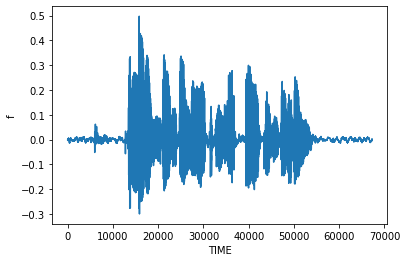

In [ ]:
# 소리 데이터 시각화
plt.plot(wav)
plt.xlabel('TIME')
plt.ylabel('f')

Text(0, 0.5, 'AMP')

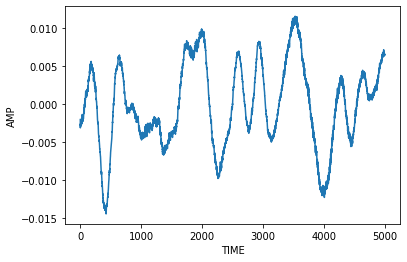

In [ ]:
# 일부 시간축 데이터만 출력
plt.plot(wav[:5000])
plt.xlabel('TIME')
plt.ylabel('AMP')

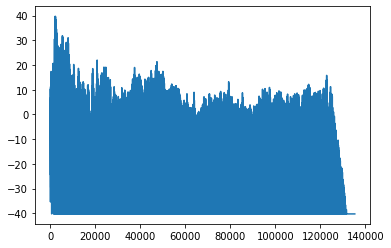

In [ ]:
# 주파수 영역으로 변환 (FT: Fourier 변환)
dB = librosa.amplitude_to_db(np.abs(librosa.stft(wav)))
plt.plot(dB.flatten())

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=30
  n_fft, y.shape[-1]


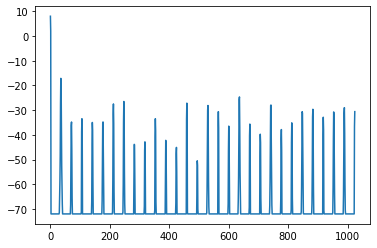

In [ ]:
# 주파수 영역으로 변환 (FT: Fourier 변환)
dB = librosa.amplitude_to_db(np.abs(librosa.stft(wav[:30])))
plt.plot(dB.flatten())

## Melospectrum : 소리데이터를 샘플링 할 때 저주파부분은 샘플링 간격을 짧게하고 고주파 부분은 길게 함 - 사람 귀가 소리를 듣는 특성을 반영
  - 소리 데이터가 이미지 데이터로 변환

  
## MFCC : Melospectrum을 디지털로 변환한 것

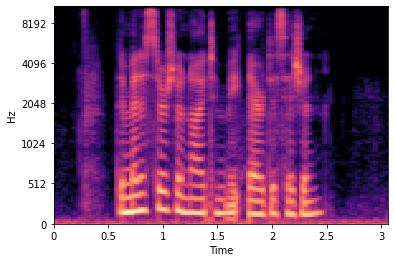

In [ ]:
# n_mels : 멜 스펙트럼의 수 (세로축의 눈금 수)
S =librosa.feature.melspectrogram(wav, sr=sr, n_mels=128)

# 시각화
log_S = librosa.power_to_db(S, ref = np.max)
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

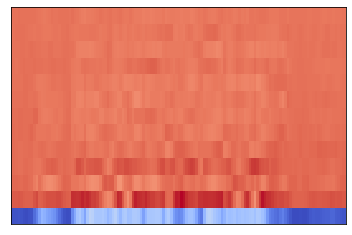

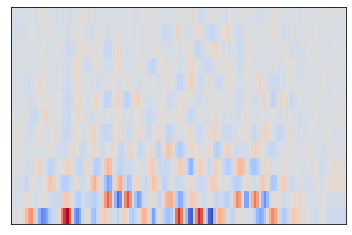

In [ ]:
# MFCC
# n_mfcc : 세로 축의 눈금의 수
mfcc = librosa.feature.mfcc(S = log_S, n_mfcc=13)

librosa.display.specshow(mfcc)
plt.show()

# 2ck alqns
mfcc2 = librosa.feature.delta(mfcc, order=2)

librosa.display.specshow(mfcc2)
plt.show()

# 아기 울음소리 인식
- 169개의 훈련데이터와 89개의 테스트데이터로 구성
- 울음소리 종류 : 울음 (crying), 웃음(laugh), 조용(silence)
- 파일이름 : 종류(인덱스).wave

- 학습내용
  1. 사운드 데이터를 DNN으로 학습해서 울음소리 인식
  2. 사운드 데이터를 Conv2로 학습해서 울음소리 인식
  3. 사운드 데이터를 MFCC으로 변환해서 Conv2D로 학습해서울음소리 인식


In [95]:
X_train= []
X_test = []
y_train = []
y_test = []

In [96]:
# 사운드 데이터를 동일한 길이로 만들어주는 함수
# (사운드 데이터, 길이)
def pad1d(wav, i):
  # 사운드 데이터가 i보다 긴경우
  if wav.shape[0] > i:
    return wav[:i]
  # 사운드 데이터가 i보다 짧은 경우
  else:
    return np.hstack(wav, np.zeros(i - wav.shape[0]))

# MFCC 데이터(2차원)를 동일한 크기로 만들어주는 함수
def pad2d(wav, i):
  if wav.shape[1] > i:
    return wav[:, :i]
  else :
    return np.hstack(wav, np.zeros(wav.shape[0]), i - wav.shape[1])

## 폴더에 있는 사운드 데이터를 특성데이터와 라벨데이터로 저장

In [97]:
import os

data_dir = '/content/drive/MyDrive/Colab Notebooks/사물지능_딥러닝_2022/baby_sound/'

train_dir = data_dir + 'train/'

# train 폴더의 사운드 파일을 읽어서 wav를 특성데이터로 저장하고 파일명을 라벨데이터로 저장
for fname in os.listdir(train_dir):
  # wav 파일이 아닌경우 아무런 처리도 하지 않음
  if ".wav" not in fname:
    continue
  
  # 파일 이름을 라벨 데이터에 저장 (crying, laugh, silence)
  # 파일이름 : 울음종류 (인덱스).wav
  label = fname.split(" ")[0]
  y_train.append(label)

  # 사운드 데이터를 같은 길이로 만들어서 특성데이터로 저장
  wav, sr = librosa.load(train_dir + fname)

  pad_x = pad1d(wav, 30000)
  X_train.append(pad_x)

In [98]:
import os

data_dir = '/content/drive/MyDrive/Colab Notebooks/사물지능_딥러닝_2022/baby_sound/'

test_dir = data_dir + 'test/'

# train 폴더의 사운드 파일을 읽어서 wav를 특성데이터로 저장하고 파일명을 라벨데이터로 저장
for fname in os.listdir(test_dir):
  # wav 파일이 아닌경우 아무런 처리도 하지 않음
  if ".wav" not in fname:
    continue
  
  # 파일 이름을 라벨 데이터에 저장 (crying, laugh, silence)
  # 파일이름 : 울음종류 (인덱스).wav
  label = fname.split(" ")[0]
  y_test.append(label)

  # 사운드 데이터를 같은 길이로 만들어서 특성데이터로 저장
  wav, sr = librosa.load(test_dir + fname)

  pad_x = pad1d(wav, 30000)
  X_test.append(pad_x)

In [66]:
# 리스트로 된 데이터를 배열의 행 데이터로 변환
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

X_train.shape, X_test.shape

((169, 30000), (178, 30000))

In [67]:
# y를 원핫 인코딩
import pandas as pd 
y_train_en = pd.get_dummies(y_train)
y_test_en = pd.get_dummies(y_test)

y_train_en.shape, y_test_en.shape

((169, 3), (178, 3))

# (1) 사운드데이터를 DNN으로 학습하기

In [68]:
X_train.shape

(169, 30000)

In [69]:
X_train[0].shape

(30000,)

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model1 = Sequential()

# 입력층
model1.add(Dense(units=512, input_shape=(30000,), activation="relu"))
model1.add(Dropout(0.3))

# 은닉층
model1.add(Dense(units=256, activation="relu"))
model1.add(Dropout(0.3))
model1.add(Dense(units=128, activation="relu"))
model1.add(Dropout(0.3))
model1.add(Dense(units=64, activation="relu"))
model1.add(Dropout(0.3))

# 출력층
model1.add(Dense(units=3, activation="softmax"))

model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 512)               15360512  
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               131328    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 64)               

In [71]:
model1.compile(loss='categorical_crossentropy',
               optimizer="adam",
               metrics=["accuracy"])

In [72]:
h1 = model1.fit(X_train, y_train_en, epochs=10, batch_size=32,
                validation_data=(X_test, y_test_en))

Epoch 1/10
6/6 [==============================] - 1s 44ms/step - loss: 0.9144 - accuracy: 0.4438 - val_loss: 0.7443 - val_accuracy: 0.4944
Epoch 2/10
6/6 [==============================] - 0s 15ms/step - loss: 1.1540 - accuracy: 0.5207 - val_loss: 0.7587 - val_accuracy: 0.7640
Epoch 3/10
6/6 [==============================] - 0s 14ms/step - loss: 0.8102 - accuracy: 0.6864 - val_loss: 0.8925 - val_accuracy: 0.7416
Epoch 4/10
6/6 [==============================] - 0s 17ms/step - loss: 0.7955 - accuracy: 0.7456 - val_loss: 0.7759 - val_accuracy: 0.8202
Epoch 5/10
6/6 [==============================] - 0s 14ms/step - loss: 0.5616 - accuracy: 0.8047 - val_loss: 0.7023 - val_accuracy: 0.8202
Epoch 6/10
6/6 [==============================] - 0s 14ms/step - loss: 0.5061 - accuracy: 0.8225 - val_loss: 0.6933 - val_accuracy: 0.8315
Epoch 7/10
6/6 [==============================] - 0s 17ms/step - loss: 0.4869 - accuracy: 0.8876 - val_loss: 0.7023 - val_accuracy: 0.7978
Epoch 8/10
6/6 [===========

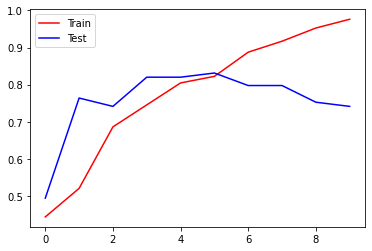

In [73]:
# 시각화
import matplotlib.pyplot as plt

plt.plot(h1.history["accuracy"], "r", label="Train")
plt.plot(h1.history["val_accuracy"], "b", label="Test")
plt.legend()

In [74]:
# 예측하기
pred = model1.predict(X_test)

print(pred[0])
print(y_test_en.iloc[0])

print(pred[3])
print(y_test_en.iloc[3])

print(pred[10])
print(y_test_en.iloc[10])

6/6 [==============================] - 0s 3ms/step
[0.16560917 0.5651628  0.26922804]
crying     1
laugh      0
silence    0
Name: 0, dtype: uint8
[0.23758048 0.41152    0.35089958]
crying     1
laugh      0
silence    0
Name: 3, dtype: uint8
[0.18549517 0.5640977  0.25040713]
crying     0
laugh      1
silence    0
Name: 10, dtype: uint8


# (2) 소리 데이터를 Conv1D를 사용하여 학습

In [75]:
# Conv1D에 입력하기 위해서 차원을 하나 증가
# 끝 인덱스에 차원하나를 증가
# conv1D 시간차원 증가,  Conv2D에서는 색상 차원 증가
X_train_ex = np.expand_dims(X_train, -1)
X_test_ex = np.expand_dims(X_test, -1)

X_train_ex.shape, X_test_ex.shape

((169, 30000, 1), (178, 30000, 1))

## 신경망 설계

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Dense, Dropout, Flatten

model2 = Sequential()

model2.add(Conv1D(filters=64, kernel_size=3, input_shape=(30000, 1), activation="relu"))
model2.add(Conv1D(filters=64, kernel_size=3, activation="relu"))
model2.add(MaxPooling1D(pool_size=3)) # 3개를 하나로 변환해줌 (10 200 50) -> 200

model2.add(Conv1D(filters=128, kernel_size=3, activation="relu"))
model2.add(Conv1D(filters=128, kernel_size=3, activation="relu"))
model2.add(GlobalAveragePooling1D())
model2.add(Dropout(0.5))

model2.add(Dense(units=3, activation="softmax"))

model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 29998, 64)         256       
                                                                 
 conv1d_5 (Conv1D)           (None, 29996, 64)         12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 9998, 64)         0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 9996, 128)         24704     
                                                                 
 conv1d_7 (Conv1D)           (None, 9994, 128)         49280     
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                             

In [77]:
model2.compile(loss='categorical_crossentropy',
               optimizer="adam",
              metrics=["accuracy"])

In [78]:
h2 = model2.fit(X_train, y_train_en, epochs=50, batch_size=32,
                validation_data=(X_test, y_test_en))

Epoch 1/50
6/6 [==============================] - 2s 261ms/step - loss: 1.0875 - accuracy: 0.3432 - val_loss: 1.0472 - val_accuracy: 0.4270
Epoch 2/50
6/6 [==============================] - 1s 210ms/step - loss: 1.0315 - accuracy: 0.4201 - val_loss: 0.9430 - val_accuracy: 0.4270
Epoch 3/50
6/6 [==============================] - 1s 191ms/step - loss: 0.9587 - accuracy: 0.4201 - val_loss: 0.8395 - val_accuracy: 0.6292
Epoch 4/50
6/6 [==============================] - 1s 208ms/step - loss: 0.8788 - accuracy: 0.6036 - val_loss: 0.7694 - val_accuracy: 0.7753
Epoch 5/50
6/6 [==============================] - 1s 207ms/step - loss: 0.8403 - accuracy: 0.6746 - val_loss: 0.6788 - val_accuracy: 0.8090
Epoch 6/50
6/6 [==============================] - 1s 192ms/step - loss: 0.7434 - accuracy: 0.7692 - val_loss: 0.5503 - val_accuracy: 0.8427
Epoch 7/50
6/6 [==============================] - 1s 187ms/step - loss: 0.6500 - accuracy: 0.7515 - val_loss: 0.4211 - val_accuracy: 0.8427
Epoch 8/50
6/6 [====

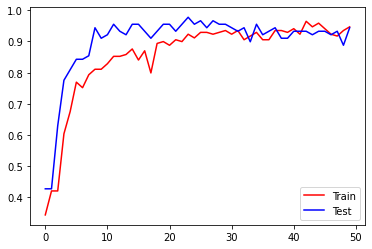

In [79]:
# 시각화
import matplotlib.pyplot as plt

plt.plot(h2.history["accuracy"], "r", label="Train")
plt.plot(h2.history["val_accuracy"], "b", label="Test")
plt.legend()

In [82]:
# 예측하기
pred = model2.predict(X_test_ex)

print(pred[0])
print(y_test_en.iloc[0])

print(pred[3])
print(y_test_en.iloc[3])

print(pred[10])
print(y_test_en.iloc[10])

6/6 [==============================] - 0s 64ms/step
[0.66276115 0.3352043  0.00203453]
crying     1
laugh      0
silence    0
Name: 0, dtype: uint8
[0.6839217  0.31464463 0.00143374]
crying     1
laugh      0
silence    0
Name: 3, dtype: uint8
[2.4794416e-01 7.5168639e-01 3.6947042e-04]
crying     0
laugh      1
silence    0
Name: 10, dtype: uint8


# (3) 소리 데이터를 Conv2D를 사용하여 학습

In [103]:
X_train = []
X_test = []
y_train = []
y_test = []

In [104]:
# 훈련 데이터 변환
for fname in os.listdir(train_dir):
  if ".wav" not in fname:
    continue

  label = fname.split(" ")[0]
  y_train.append(label)

  wav, sr = librosa.load(train_dir + fname)
  mfcc = librosa.feature.mfcc(wav)

  pad_x = pad2d(mfcc, 40)
  X_train.append(pad_x)

In [105]:
# 훈련 데이터 변환
for fname in os.listdir(test_dir):
  if ".wav" not in fname:
    continue

  label = fname.split(" ")[0]
  y_test.append(label)

  wav, sr = librosa.load(test_dir + fname)
  mfcc = librosa.feature.mfcc(wav)

  pad_x = pad2d(mfcc, 40)
  X_test.append(pad_x)

In [106]:
# 리스트를 배열로 변화
X_train = np.array(X_train)
X_test = np.array(X_test)

y_train_en = pd.get_dummies(y_train)
y_test_en = pd.get_dummies(y_test)

X_train.shape, X_test.shape, y_train_en.shape, y_test_en.shape

((169, 20, 40), (89, 20, 40), (169, 3), (89, 3))

In [107]:
X_train_ex = np.expand_dims(X_train, -1)
X_test_ex = np.expand_dims(X_test, -1)

X_train_ex.shape, X_test_ex.shape

((169, 20, 40, 1), (89, 20, 40, 1))

In [122]:
# 신경망 설계
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout
model3 = Sequential()
model3.add(Conv2D(filters=64, kernel_size=(3, 3),
                  input_shape=(20, 40, 1), activation="relu"))
model3.add(GlobalAveragePooling2D())
#model3.add(Dropout(0.5))
model3.add(Dense(units=128, activation="relu"))
model3.add(Dropout(0.3))
model3.add(Dense(units=64, activation="relu"))
model3.add(Dropout(0.3))
model3.add(Dense(units=32, activation="relu"))
model3.add(Dropout(0.3))
model3.add(Dense(units=3, activation="softmax"))
model3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 18, 38, 64)        640       
                                                                 
 global_average_pooling2d_3   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_33 (Dense)            (None, 128)               8320      
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                     

In [123]:
model3.compile(loss='categorical_crossentropy',
               optimizer="adam",
              metrics=["accuracy"])

In [124]:
h3 = model3.fit(X_train_ex, y_train_en, epochs=50, batch_size=32,
                validation_data=(X_test_ex, y_test_en))

Epoch 1/50
6/6 [==============================] - 1s 38ms/step - loss: 1.3157 - accuracy: 0.4556 - val_loss: 0.6488 - val_accuracy: 0.8539
Epoch 2/50
6/6 [==============================] - 0s 8ms/step - loss: 0.9115 - accuracy: 0.5917 - val_loss: 0.5092 - val_accuracy: 0.8539
Epoch 3/50
6/6 [==============================] - 0s 8ms/step - loss: 0.6922 - accuracy: 0.7574 - val_loss: 0.3935 - val_accuracy: 0.8539
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 0.6231 - accuracy: 0.7811 - val_loss: 0.3493 - val_accuracy: 0.8539
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 0.5669 - accuracy: 0.7574 - val_loss: 0.3500 - val_accuracy: 0.8539
Epoch 6/50
6/6 [==============================] - 0s 8ms/step - loss: 0.4663 - accuracy: 0.8166 - val_loss: 0.3307 - val_accuracy: 0.8539
Epoch 7/50
6/6 [==============================] - 0s 10ms/step - loss: 0.4469 - accuracy: 0.8225 - val_loss: 0.2771 - val_accuracy: 0.8539
Epoch 8/50
6/6 [================

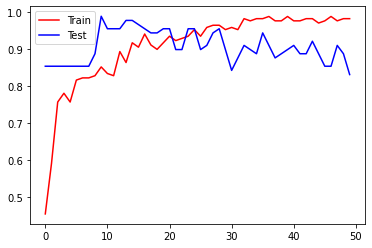

In [125]:
# 시각화
import matplotlib.pyplot as plt

plt.plot(h3.history["accuracy"], "r", label="Train")
plt.plot(h3.history["val_accuracy"], "b", label="Test")
plt.legend()

In [127]:
# 예측하기
pred = model3.predict(X_test_ex)

print(pred[0])
print(y_test_en.iloc[0])

print(pred[3])
print(y_test_en.iloc[3])

print(pred[10])
print(y_test_en.iloc[10])

3/3 [==============================] - 0s 4ms/step
[0.9873897  0.00817539 0.00443491]
crying     1
laugh      0
silence    0
Name: 0, dtype: uint8
[0.9753668  0.01644067 0.00819255]
crying     1
laugh      0
silence    0
Name: 3, dtype: uint8
[1.7046279e-06 9.9999797e-01 3.5159744e-07]
crying     0
laugh      1
silence    0
Name: 10, dtype: uint8
